In [10]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [11]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [12]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [13]:
def factor(df, window=20):
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        up_mask = group['return'] > 0
        down_mask = group['return'] < 0
        
        # 成交量加权处理
        if up_mask.any():
            up_weights = group.loc[up_mask, 'return'].abs() * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        if down_mask.any():
            down_weights = group.loc[down_mask, 'return'].abs() * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna(subset=['G_u', 'G_d'])
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    daily_df['factor'] = daily_df['residual'].rolling(window).mean()
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.024195
   Rank_IC (Spearman): 0.024765
📊 信息比率:
   IR: 0.543110
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


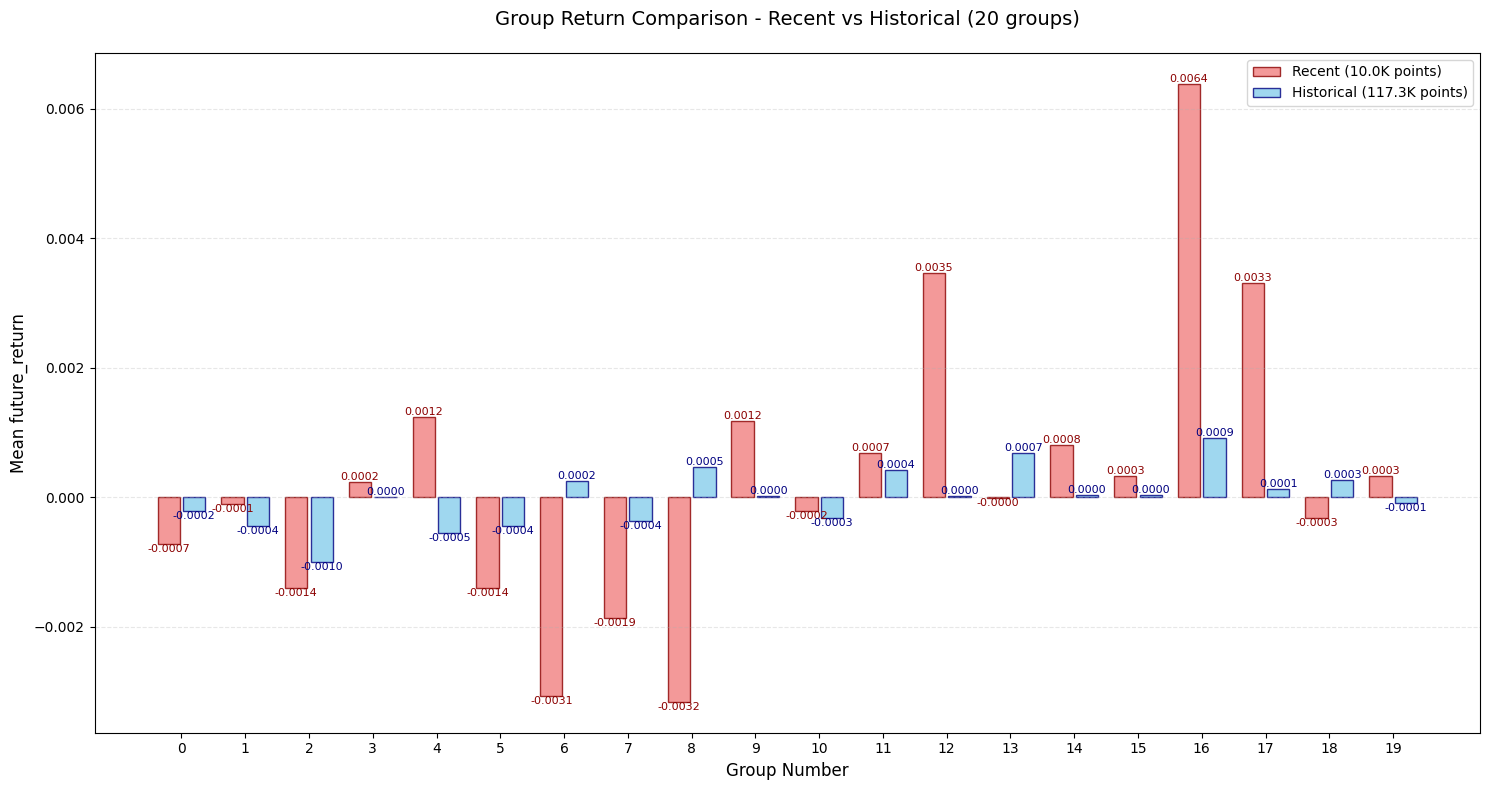

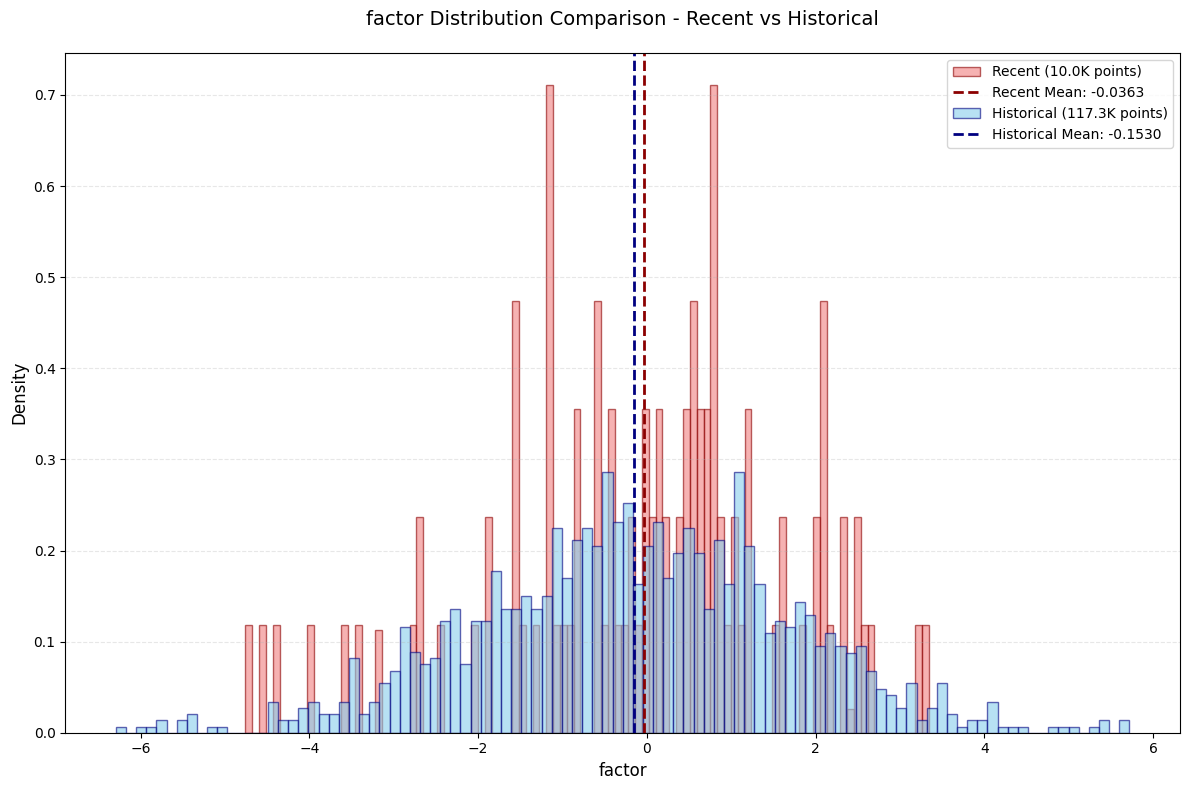

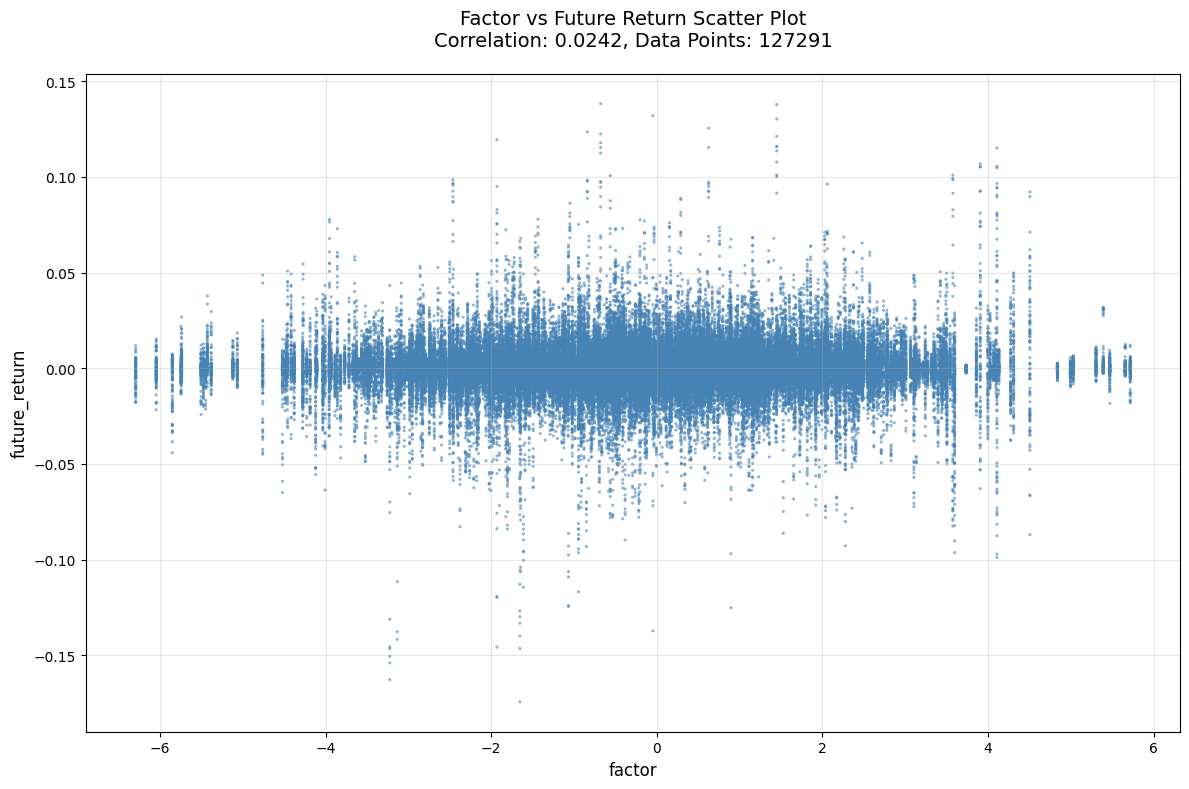

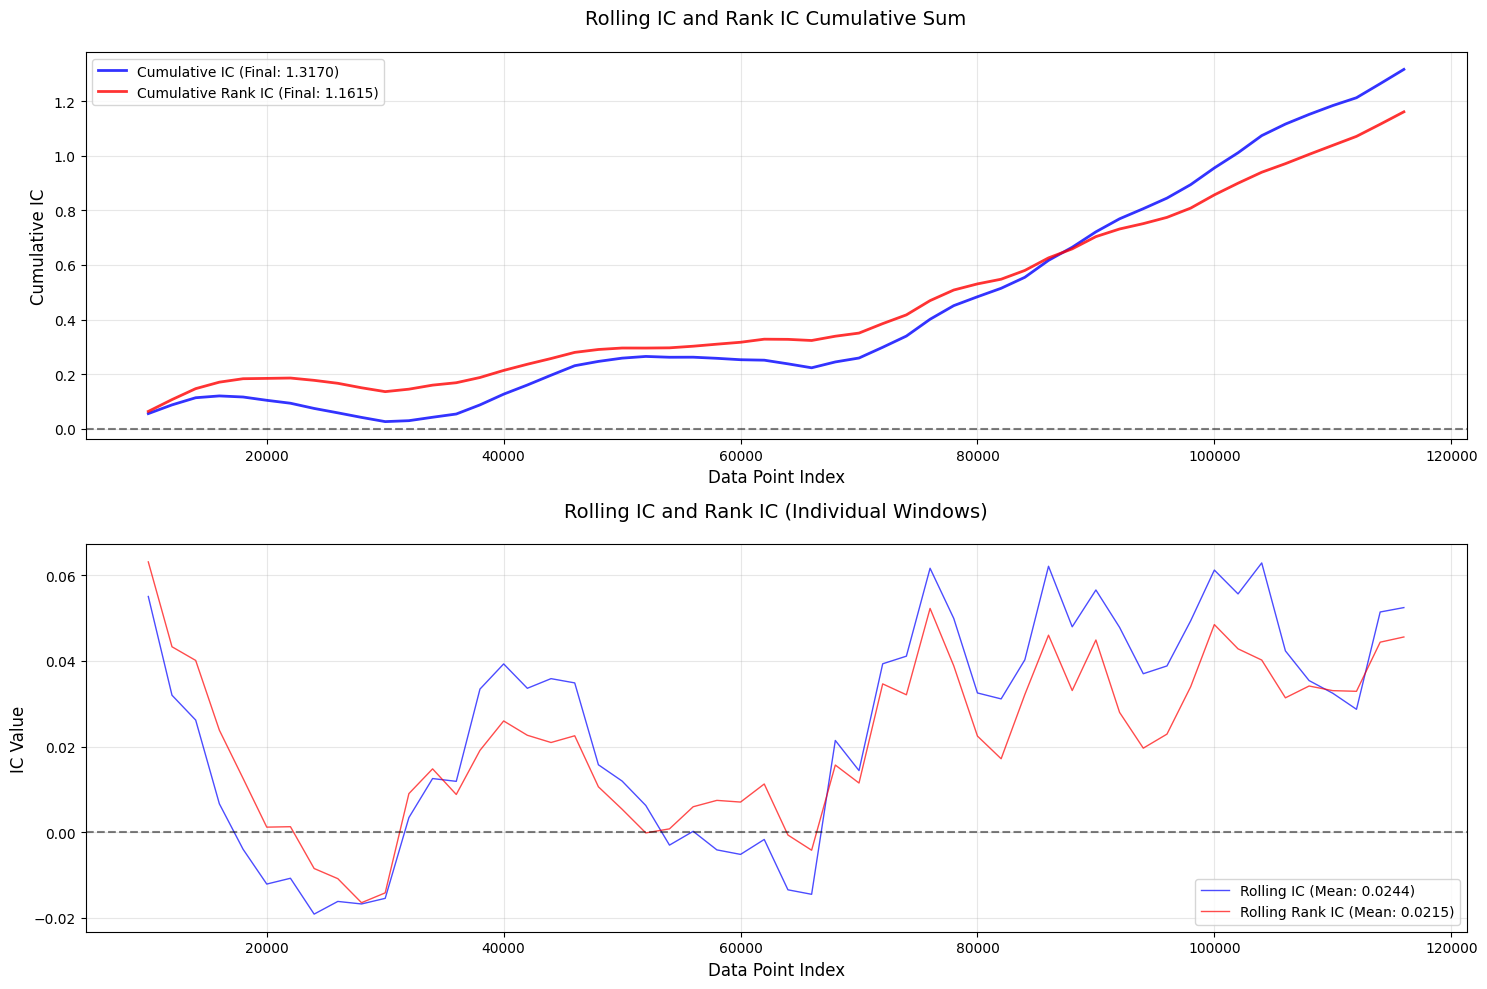

✅ 已显示 4 个图片
----------------------------------------


In [14]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [15]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.0019764869900197224,
 0.04075945838677773,
 0.037653395787209776,
 0.015520020004013143,
 0.002530391213563906,
 0.0199979202663773,
 0.028561151616474396,
 -0.009058202958755139,
 -0.02969372117414714,
 0.008457955878169965]

In [16]:
print(result)

{'correlation_analysis': {'IC': 0.02419501066602169, 'Rank_IC': 0.024764644729254544}, 'information_ratio': {'IR': 0.5431095590580078, 'group_correlations': [-0.0019764869900197224, 0.04075945838677773, 0.037653395787209776, 0.015520020004013143, 0.002530391213563906, 0.0199979202663773, 0.028561151616474396, -0.009058202958755139, -0.02969372117414714, 0.008457955878169965], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -6.2928  -3.1975   -4.1128      -0.0002      0.0121   6432
1      -3.1613  -2.5575   -2.8274      -0.0004      0.0102   6331
2      -2.5531  -2.0498   -2.2913      -0.0009      0.0123   6336
3      -2.0284  -1.6646   -1.8472      -0.0003      0.0128   6432
4      -1.6626  -1.3476   -1.5022      -0.0004      0.0132   6336
5      -1.3384  -1.0255   -1.1658      -0.0001      0.0103   6336
6      -1.0252  -0.7738   -0.8981      -0.